# Song Recommender: K-Means (clustering)

#### Ironhack July 2022

This project consists on creating a song recommender based on the audio features identified by Spotify. In this notebook, our main goal is to build two song databases (one for Hot 100 songs from Billboard, the other one from Kaggle), get the features for each song and create clusters to categorize and divide the songs.

In this notebook, we're going to test some K-Means models in order to get the one with the best results for our songs database.

#### Libraries:

In [84]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pickle
import yaml

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Getting parameters from YAML file:

In [85]:
try: 
    with open ("params.yaml", 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print('Error reading the config file')

Loading our combined dataframe (that contains popular and not so popular songs)

In [43]:
df_features = pd.read_csv(config['data']['combined_data'])
df_features = df_features.select_dtypes(include='number')
df_features.head()

# Getting rid of unnecesary columns
df_features.drop('Unnamed: 0', axis = 1, inplace = True)

How does our data look like?

In [44]:
round(df_features.describe(),2)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,5622.00,5622.00,5622.00,5622.00,5622.00,5622.00,5622.00,5622.00,5622.00,5622.00,5622.00,5622.00
mean,0.56,0.67,5.32,-7.81,0.66,0.07,0.23,0.12,0.20,0.51,122.62,245307.62
std,0.17,0.22,3.57,3.76,0.47,0.08,0.29,0.26,0.17,0.25,28.60,96919.01
min,0.00,0.00,0.00,-38.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7712.00
25%,0.45,0.52,2.00,-9.50,0.00,0.03,0.01,0.00,0.09,0.31,100.43,199616.50
50%,0.56,0.71,5.00,-7.01,1.00,0.04,0.08,0.00,0.13,0.51,121.13,233747.00
75%,0.68,0.85,9.00,-5.22,1.00,0.07,0.36,0.04,0.26,0.71,140.70,274153.25
max,0.98,1.00,11.00,2.64,1.00,0.95,1.00,0.99,0.99,0.99,216.02,3025000.00


As K-Means is a distance based algorithm, we need to scale our data. To do so, we are going to use StandardScaler. As we already know the best parameters for the K-Means clustering algorithm, we won't save all the scalers and models, just the one that we'll use later with our song recommender. Even so, it is interesting to see the performance of each model based on the chosen parameters.

In [45]:
scaler = StandardScaler()
scaler.fit(df_features)
df_scaled = scaler.transform(df_features)

In [46]:
df_scaled = pd.DataFrame(df_scaled, columns = df_features.columns)
print('Original data:')
display(df_features.head())
print()
print('Scaled data:')
display(df_scaled.head())

Original data:


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.950,0.891,2,-2.653,1,0.2410,0.0645,0.000018,0.3090,0.912,133.010,170977
1,0.520,0.731,6,-5.338,0,0.0557,0.3420,0.001010,0.3110,0.662,173.930,167303
2,0.836,0.743,10,-6.305,0,0.0656,0.0995,0.000000,0.3350,0.722,108.966,191822
3,0.687,0.887,1,-5.040,0,0.0826,0.0575,0.000002,0.2700,0.853,114.941,278282
4,0.629,0.547,10,-13.123,0,0.0550,0.7200,0.003140,0.0604,0.197,108.375,298933



Scaled data:


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,2.347691,0.993361,-0.929071,1.371810,0.715614,1.987215,-0.560350,-0.460235,0.616233,1.618236,0.363155,-0.767004
1,-0.235941,0.281261,0.191254,0.658174,-1.397402,-0.229102,0.405794,-0.456415,0.627685,0.612275,1.793854,-0.804915
2,1.662728,0.334669,1.311580,0.401158,-1.397402,-0.110692,-0.438494,-0.460304,0.765114,0.853706,-0.477503,-0.551908
3,0.767470,0.975558,-1.209152,0.737378,-1.397402,0.092640,-0.584721,-0.460295,0.392912,1.380829,-0.268598,0.340256
4,0.418980,-0.537654,1.311580,-1.410972,-1.397402,-0.237475,1.721839,-0.448215,-0.807293,-1.258812,-0.498167,0.553350


#### Looking for correlations

In order to choose the features, we asked ourselves if there was some kind of correlation between them. Besides the obvious correlations (the higher the energy, the lower the acousticness), we are not able to identify any relevant information.

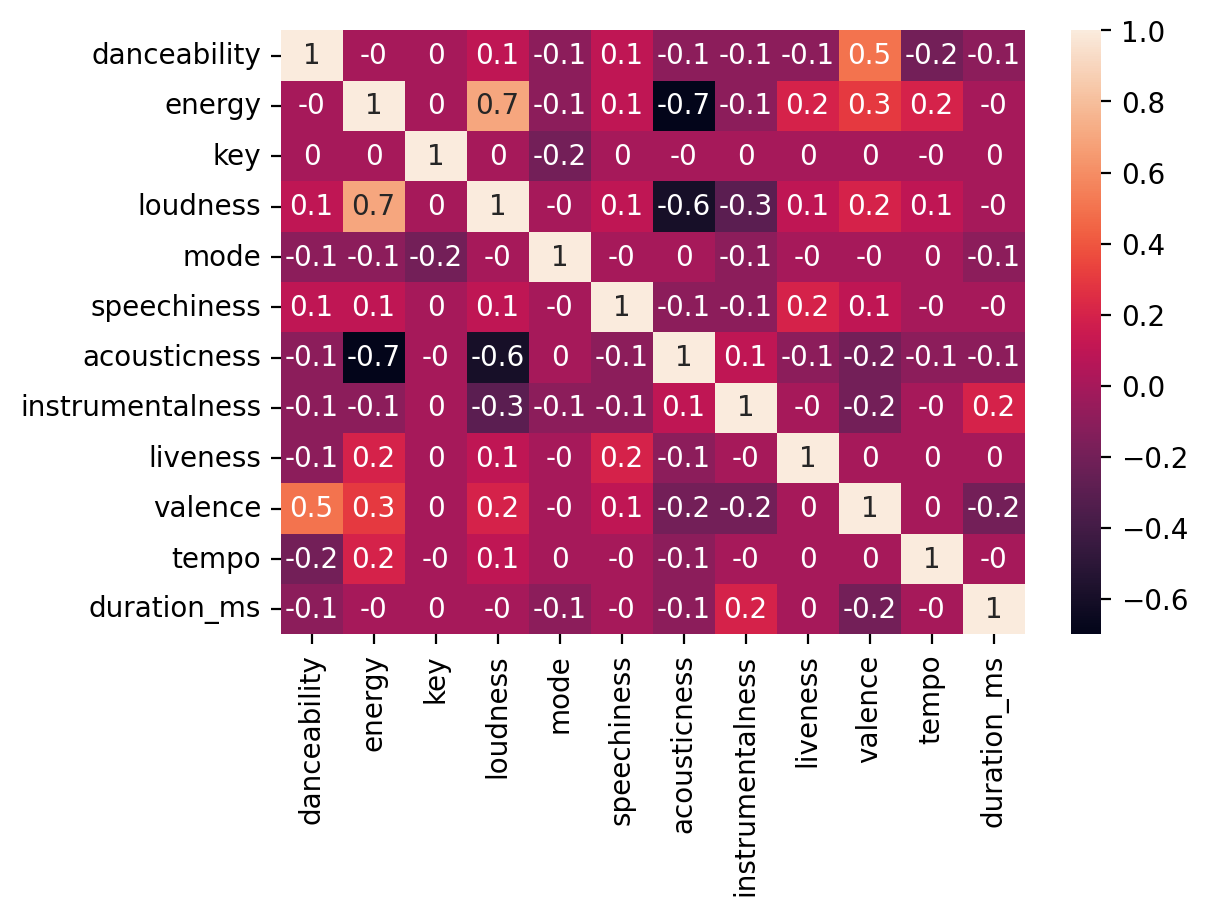

In [47]:
corr = df_scaled.corr()
fig, ax = plt.subplots(dpi=200)
sns.heatmap(round(corr,1), annot = True)
plt.show()

Let's "play" with the parameters of K-Means to identify which one would be the best K_neighbour.

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

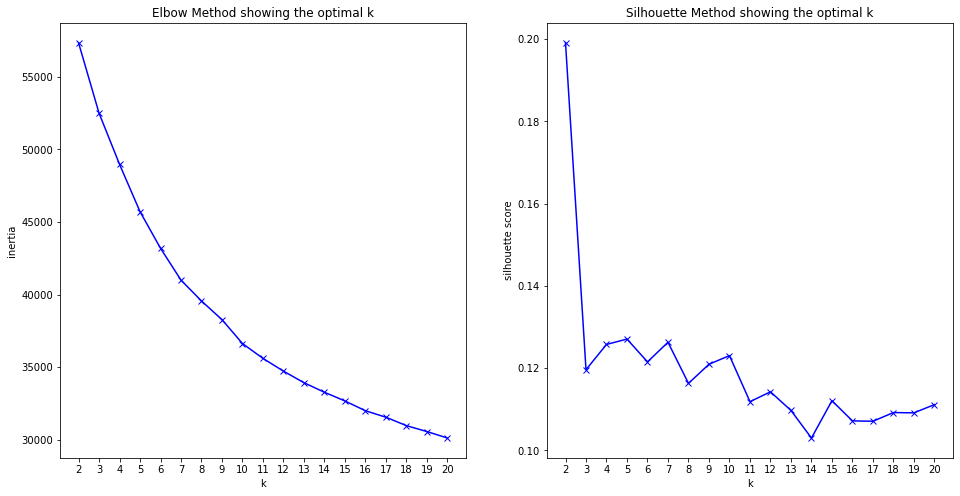

In [48]:
K = range(2, 21)
inertia = []
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters = k,
                    random_state = config['k_means']['random_state'])
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(df_scaled, kmeans.predict(df_scaled)))

# Plot the results
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(K, inertia, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('inertia')
ax[0].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[0].set_title('Elbow Method showing the optimal k')
ax[1].plot(K, silhouette, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('silhouette score')
ax[1].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[1].set_title('Silhouette Method showing the optimal k')

Although the best k_neighbours seems to be 2, if we pay attention to the silhoutte score we can see that the values are very low. Let's see if we can improve these values by reducing the number of features. After going back and forth with this topic, we have decided to keep the following features:

- Danceability: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

- Energy: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

- Acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 

- Instrumentalness: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

- Valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

In [49]:
df_scaled_red = df_scaled[['danceability', 'energy', 'acousticness', 'instrumentalness', 'valence']]
df_scaled_red.head()

,danceability,energy,acousticness,instrumentalness,valence
0,2.347691,0.993361,-0.560350,-0.460235,1.618236
1,-0.235941,0.281261,0.405794,-0.456415,0.612275
2,1.662728,0.334669,-0.438494,-0.460304,0.853706
3,0.767470,0.975558,-0.584721,-0.460295,1.380829
4,0.418980,-0.537654,1.721839,-0.448215,-1.258812


Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

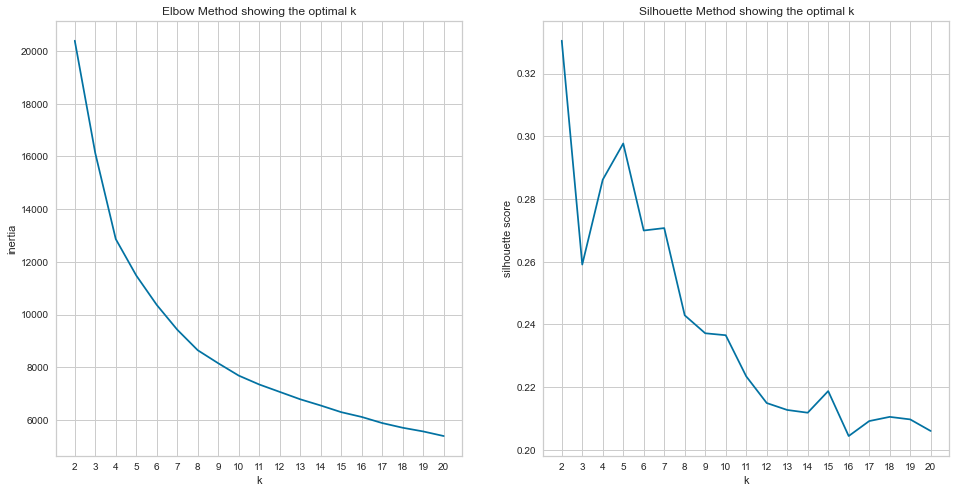

In [57]:
K = range(2, 21)
inertia = []
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters = k,
                    random_state = config['k_means']['random_state'])

    kmeans.fit(df_scaled_red)
    filename = "../Models/kmeans_" + str(k) + ".pickle" # Path with filename
    with open(filename, "wb") as file:
        pickle.dump(kmeans, file)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(df_scaled_red, kmeans.predict(df_scaled_red)))

fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(K, inertia, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('inertia')
ax[0].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[0].set_title('Elbow Method showing the optimal k')
ax[1].plot(K, silhouette, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('silhouette score')
ax[1].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[1].set_title('Silhouette Method showing the optimal k')

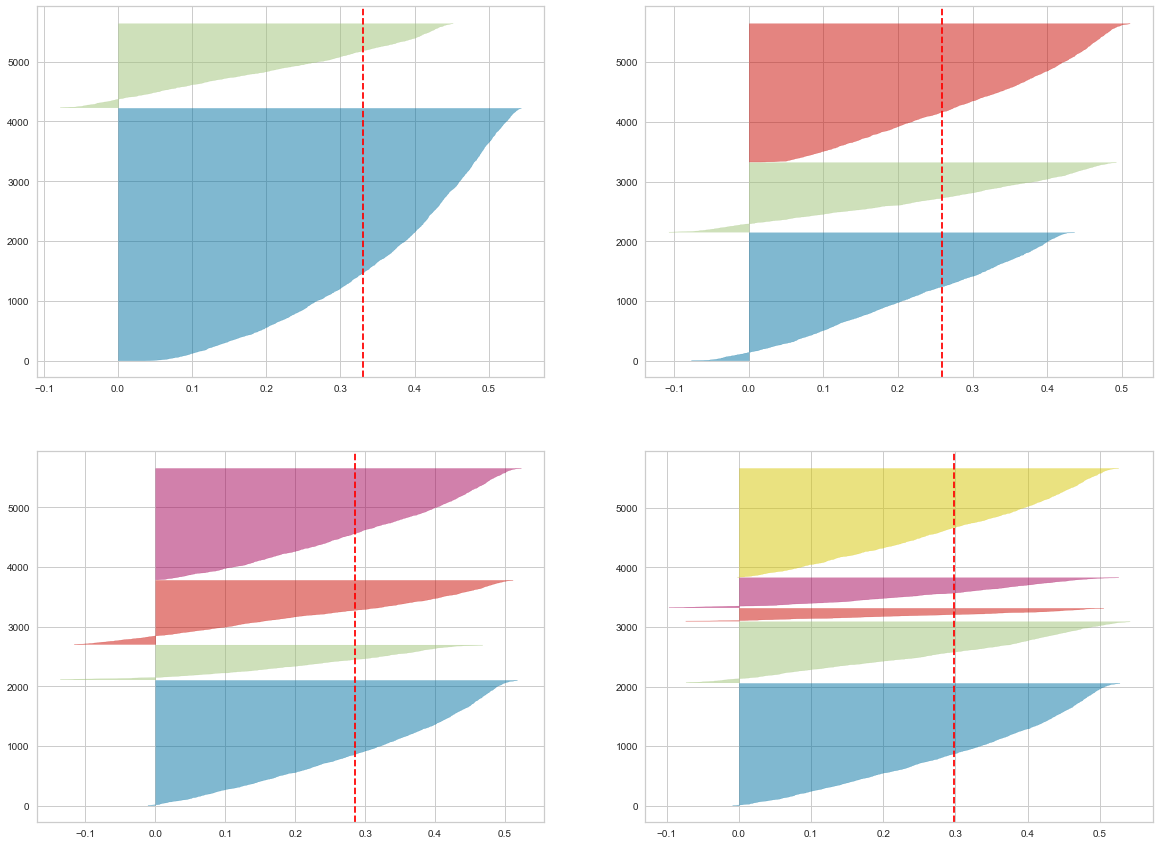

In [61]:
fig, ax = plt.subplots(2, 2, figsize=(20,15))
axs = 2 
for i in [2,3,4,5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, random_state=config['k_means']['random_state'])
          
    q, mode = divmod(axs, 2)
    
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mode])
    visualizer.fit(df_scaled_red)
    axs+=1

Altought the Silhoutte Score gives us a higher score for k=5, we're going to use the k=4 because the fifth clusters seems to be pretty small (as shown in the chart above).

# ------------------------------------------------------- #

In [77]:
with open('../Models/kmeans_4.pickle', 'rb') as file2:
    main_4 = pickle.load(file2)

print('Chosen KMeans model:')
main_4

Chosen KMeans model:


KMeans(n_clusters=4, random_state=1234)

In [88]:
songs_clustered = pd.read_csv(config['data']['combined_data'])
songs_clustered.drop('Unnamed: 0', axis = 1)

KeyError: "['Unnamed: 0'] not found in axis"

Add column with cluster labels

In [89]:
songs_clustered['clusters'] = main_4.labels_
songs_clustered.columns

Index(['title', 'artist', 'id', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'uri', 'track_href', 'duration_ms', 'label',
       'links', 'clusters'],
      dtype='object')

Create .csv file

In [90]:
songs_clustered.to_csv(config['data']['clustered_songs'], index=False)